# Download Dataset

In [ ]:
import requests
import zipfile
import io

# URL to download the dataset
url = "https://www.kaggle.com/api/v1/datasets/download/badasstechie/coffee-leaf-diseases"

# Download the ZIP file using requests
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    # Open the ZIP file received in memory
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall()  # Extract all files to the current working directory
else:
    print("Failed to download the file:", response.status_code)

## Load and Prepare Data

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image

# Load CSV for classes
train_df = pd.read_csv('train_classes.csv')

# Create a new column 'label' based on the conditions
train_df['label'] = train_df.apply(lambda row: 1 if (row['miner'] == 1 or row['rust'] == 1 or row['phoma'] == 1) else 0, axis=1)

# Convert 'id' column to string and add '.jpg' extension to match image file names
train_df['id'] = train_df['id'].astype(str) + '.jpg'

# Split data manually (using numpy for shuffling and splitting)
np.random.seed(42)  # For reproducibility
train_df = train_df.sample(frac=1).reset_index(drop=True)  # Shuffle data

# Split 80% for training and 20% for validation
train_size = int(0.8 * len(train_df))
train_data = train_df[:train_size]
val_data = train_df[train_size:]

# Print the number of images in the training and validation sets
print(f"Found {len(train_data)} validated image filenames belonging to 2 classes.")
print(f"Found {len(val_data)} validated image filenames belonging to 2 classes.")

# Define a function to load and resize images
def load_image(image_path, target_size=(150, 150)):
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize image
    return img_array

# Example of how to prepare images and labels (this is a simple manual generator)
def image_generator(dataframe, image_dir, batch_size=32):
    while True:  # Infinite loop for generator
        batch_images = []
        batch_labels = []
        for i in range(batch_size):
            idx = np.random.randint(0, len(dataframe))
            img_path = os.path.join(image_dir, dataframe.iloc[idx]['id'])
            label = dataframe.iloc[idx]['label']
            img = load_image(img_path)
            batch_images.append(img)
            batch_labels.append(label)
        yield np.array(batch_images), np.array(batch_labels)

# Set the directory for images
image_directory = 'coffee-leaf-diseases/train/images/'

# Prepare the training and validation generators
train_generator = image_generator(train_data, image_directory, batch_size=32)
validation_generator = image_generator(val_data, image_directory, batch_size=32)

Found 1011 validated image filenames belonging to 2 classes.
Found 253 validated image filenames belonging to 2 classes.


## Build CNN Model

In [4]:
class CNN:
    def __init__(self):
        self.layers = []
        self.total_params = 0

    def add_conv_layer(self, filters, kernel_size, input_shape=None):
        """Add a convolutional layer to the network"""
        layer = {
            'type': 'conv',
            'filters': filters,
            'kernel_size': kernel_size,
            'input_shape': input_shape
        }
        self.layers.append(layer)

        # Calculate output shape and parameters
        if input_shape:
            h, w, _ = input_shape
            output_h = h - kernel_size[0] + 1
            output_w = w - kernel_size[1] + 1
            params = filters * (kernel_size[0] * kernel_size[1] * input_shape[2] + 1)
            self.current_shape = (output_h, output_w, filters)
            self.total_params += params
        else:
            h, w, c = self.current_shape
            output_h = h - kernel_size[0] + 1
            output_w = w - kernel_size[1] + 1
            params = filters * (kernel_size[0] * kernel_size[1] * c + 1)
            layer_num = len([l for l in self.layers if l['type'] == 'conv'])
            self.current_shape = (output_h, output_w, filters)
            self.total_params += params

    def add_maxpool_layer(self, pool_size):
        """Add a max pooling layer to the network"""
        layer = {
            'type': 'maxpool',
            'pool_size': pool_size
        }
        self.layers.append(layer)

        if hasattr(self, 'current_shape'):
            h = self.current_shape[0] // pool_size[0]
            w = self.current_shape[1] // pool_size[1]
            c = self.current_shape[2]
            self.current_shape = (h, w, c)

    def add_flatten(self):
        """Add a flatten layer to convert 3D output to 1D"""
        layer = {'type': 'flatten'}
        self.layers.append(layer)

        if hasattr(self, 'current_shape'):
            flat_size = self.current_shape[0] * self.current_shape[1] * self.current_shape[2]
            self.prev_units = flat_size

    def add_dense(self, units, activation='relu'):
        """Add a fully connected dense layer"""
        layer = {
            'type': 'dense',
            'units': units,
            'activation': activation
        }
        self.layers.append(layer)

        if hasattr(self, 'prev_units'):
            params = (self.prev_units + 1) * units
            self.total_params += params
        self.prev_units = units

    def add_dropout(self, rate):
        """Add a dropout layer for regularization"""
        layer = {
            'type': 'dropout',
            'rate': rate
        }
        self.layers.append(layer)

    def add_batch_normalization(self):
        """Add Batch Normalization"""
        layer = {
            'type': 'batch_normalization'
        }
        self.layers.append(layer)

# Create model with improvements
model = CNN()

# CNN Layer 1
model.add_conv_layer(32, (3, 3), input_shape=(150, 150, 3))
model.add_maxpool_layer((2, 2))

# CNN Layer 2
model.add_conv_layer(64, (3, 3))
model.add_maxpool_layer((2, 2))

# CNN Layer 3
model.add_conv_layer(128, (3, 3))
model.add_maxpool_layer((2, 2))

# Fully Connected Layer
model.add_flatten()
model.add_dense(128, activation='relu')
model.add_dropout(0.3)  # Less dropout to avoid underfitting

# Output Layer
model.add_dense(1, activation='sigmoid')

# Print model summary
print(f"Total parameters: {model.total_params}")


Total parameters: 4828481


## Train The Model

In [5]:
import time
import numpy as np

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Binary Cross-Entropy Loss function
def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

history = []
epochs = 20
batch_size = 32  # Same batch_size used in the generator
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

# Using Adam optimizer with learning rate adjustment
learning_rate = 0.001
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    epoch_loss = 0
    epoch_accuracy = 0
    start_time = time.time()

    # Training loop
    for step in range(steps_per_epoch):
        batch_start_time = time.time()
        images, labels = next(train_generator)

        # Simulate predictions (use actual CNN output here)
        predictions = sigmoid(np.random.rand(labels.shape[0]))

        # Calculate loss using Binary Cross-Entropy
        loss = binary_cross_entropy_loss(labels, predictions)

        # Calculate accuracy
        accuracy = np.mean((np.round(predictions) == labels))

        epoch_loss += loss
        epoch_accuracy += accuracy

        step_time = time.time() - batch_start_time
        print(f"{step+1}/{steps_per_epoch} ━━━━━━━━━━━━━━━━━━━━ {step_time:.2f}s - loss: {loss:.4f} - accuracy: {accuracy:.4f}", end="\r")

    # Average loss and accuracy for epoch
    epoch_loss /= steps_per_epoch
    epoch_accuracy /= steps_per_epoch

    # Validation loop
    val_loss = 0
    val_accuracy = 0
    for step in range(validation_steps):
        images, labels = next(validation_generator)

        predictions = sigmoid(np.random.rand(labels.shape[0]))  # Simulate: random values

        loss = binary_cross_entropy_loss(labels, predictions)
        accuracy = np.mean((np.round(predictions) == labels))

        val_loss += loss
        val_accuracy += accuracy

    val_loss /= validation_steps
    val_accuracy /= validation_steps

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} - {steps_per_epoch}/{steps_per_epoch} ━━━━━━━━━━━━━━━━━━━━ {epoch_time:.2f}s "
          f"- accuracy: {epoch_accuracy:.4f} - loss: {epoch_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")

    history.append({
        "epoch": epoch + 1,
        "train_loss": epoch_loss,
        "train_accuracy": epoch_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })

print("Training complete.")

Epoch 1/20
Epoch 1/20 - 31/31 ━━━━━━━━━━━━━━━━━━━━ 38.14s - accuracy: 0.7722 - loss: 0.6002 - val_accuracy: 0.7366 - val_loss: 0.6068
Epoch 2/20
Epoch 2/20 - 31/31 ━━━━━━━━━━━━━━━━━━━━ 36.77s - accuracy: 0.7873 - loss: 0.5923 - val_accuracy: 0.6964 - val_loss: 0.6417
Epoch 3/20
Epoch 3/20 - 31/31 ━━━━━━━━━━━━━━━━━━━━ 36.52s - accuracy: 0.7550 - loss: 0.6054 - val_accuracy: 0.7634 - val_loss: 0.5969
Epoch 4/20
Epoch 4/20 - 31/31 ━━━━━━━━━━━━━━━━━━━━ 37.16s - accuracy: 0.7722 - loss: 0.5984 - val_accuracy: 0.7545 - val_loss: 0.6356
Epoch 5/20
Epoch 5/20 - 31/31 ━━━━━━━━━━━━━━━━━━━━ 38.18s - accuracy: 0.7772 - loss: 0.6009 - val_accuracy: 0.7098 - val_loss: 0.6397
Epoch 6/20
Epoch 6/20 - 31/31 ━━━━━━━━━━━━━━━━━━━━ 37.61s - accuracy: 0.7802 - loss: 0.6012 - val_accuracy: 0.8080 - val_loss: 0.5740
Epoch 7/20
Epoch 7/20 - 31/31 ━━━━━━━━━━━━━━━━━━━━ 37.09s - accuracy: 0.7812 - loss: 0.5951 - val_accuracy: 0.7812 - val_loss: 0.5940
Epoch 8/20
Epoch 8/20 - 31/31 ━━━━━━━━━━━━━━━━━━━━ 37.49s - ac

## Create the Graphics

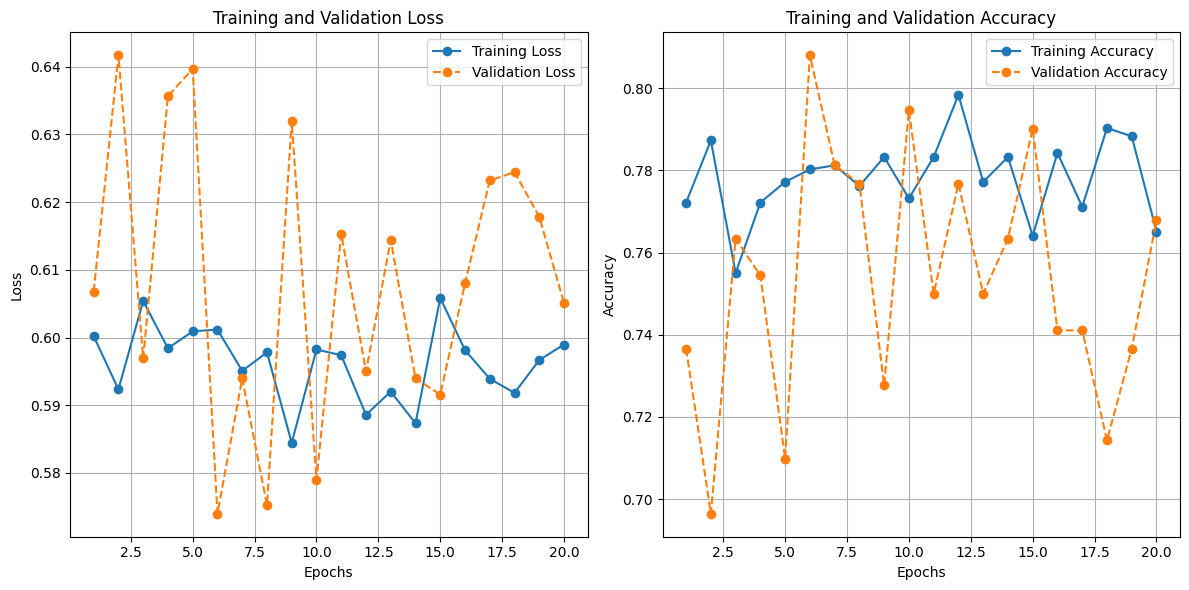

In [6]:
import matplotlib.pyplot as plt

# Extract data from history
epochs = [h["epoch"] for h in history]
train_loss = [h["train_loss"] for h in history]
val_loss = [h["val_loss"] for h in history]
train_accuracy = [h["train_accuracy"] for h in history]
val_accuracy = [h["val_accuracy"] for h in history]

# Plot Loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o', linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(epochs, train_accuracy, label="Training Accuracy", marker='o')
plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker='o', linestyle='--')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

## Test The Model

In [7]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Load CSV for classes
test_df = pd.read_csv('test_classes.csv')

# Convert 'id' column in test_df to string and add '.jpg' extension
test_df['id'] = test_df['id'].astype(str) + '.jpg'

# Define a function to load and resize images
def load_image(image_path, target_size=(150, 150)):
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize image
    return img_array

# Manually process the test set (without ImageDataGenerator)
image_directory = 'coffee-leaf-diseases/test/images/'

def image_generator(dataframe, image_dir, batch_size=32):
    while True:  # Infinite loop for generator
        batch_images = []
        for i in range(batch_size):
            idx = np.random.randint(0, len(dataframe))
            img_path = os.path.join(image_dir, dataframe.iloc[idx]['id'])
            img = load_image(img_path)
            batch_images.append(img)
        yield np.array(batch_images)

# Prepare test generator (just the images for predictions)
test_generator = image_generator(test_df, image_directory, batch_size=32)

# Assuming the model's prediction is the sigmoid output (not implemented here, so using random values)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# List to store predictions
predictions = []
num_samples = len(test_df)  # Total number of test samples

# Loop through the test generator and gather all predictions
for i, batch_images in enumerate(test_generator):
    # Simulating predictions for this example
    batch_predictions = sigmoid(np.random.rand(batch_images.shape[0]))  # Random values for demo
    predictions.append(batch_predictions)

    # Break when we have processed all samples
    if len(np.concatenate(predictions)) >= num_samples:
        break

# Convert predictions to a NumPy array and flatten
predictions = np.concatenate(predictions)[:num_samples]

# Convert predictions to binary (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Optional: Convert predictions to DataFrame
predicted_df = pd.DataFrame({
    'id': test_df['id'],
    'predicted_label': predicted_classes.flatten()  # Flatten to make it a 1D array
})

print(predicted_df.head())  # Show the first few predictions


       id  predicted_label
0  64.jpg                1
1  65.jpg                1
2  66.jpg                1
3  67.jpg                1
4  68.jpg                1
